[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


d:\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


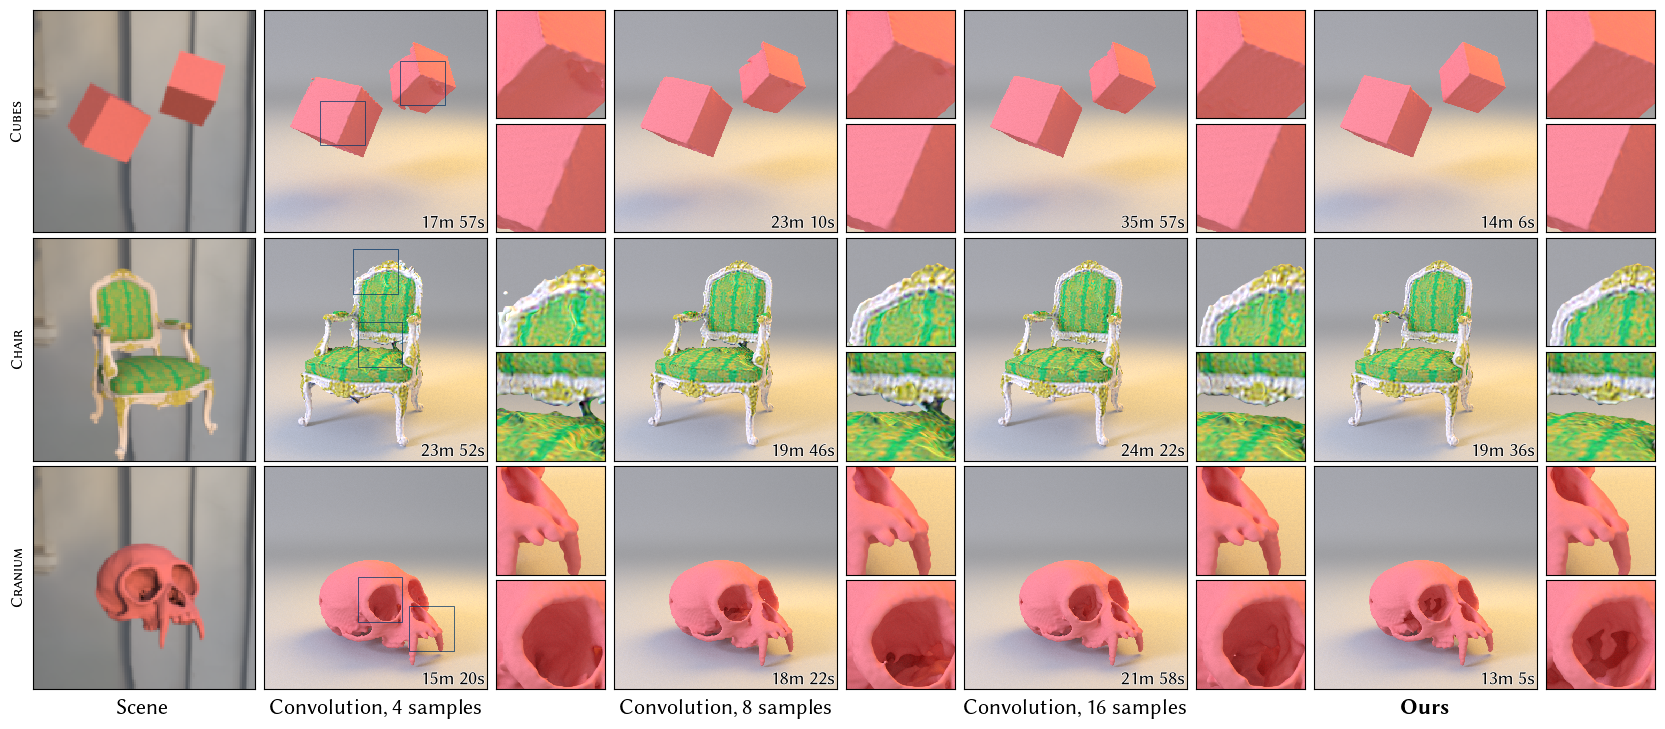

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('../'))
from common import *
import configs
import opt_configs

from constants import OUTPUT_DIR
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import json

from conv_opt_results import results

fig_name = 'conv_opt_results'
fig_dir = join(FIGURE_DIR, fig_name)
used_configs = [configs.ConvolutionWarp4(), configs.ConvolutionWarp8(), configs.ConvolutionWarp16(), configs.Warp()]
names = ['Convolution, 4 samples', 'Convolution, 8 samples', 'Convolution, 16 samples', '\\textbf{Ours}']

fontsize = 16
base_size = 3
n_rows = len(results)
n_cols = 2 * len(used_configs) + 1
total_width = base_size * (len(used_configs) + 1 + 0.5 * len(used_configs))
fig = plt.figure(1, figsize=(total_width, 0.98 * n_rows * base_size), constrained_layout=False)
width_ratios = [1, ] * n_cols
for col in range(1, n_cols):
    if col % 2 == 0:
        width_ratios[col] /= 2

gs = fig.add_gridspec(n_rows, n_cols, wspace=0.025, hspace=0.025, width_ratios=width_ratios)

inset_size = 0.2
y_offset = -0.08

ranges = [5e-7, 2e-6, 5e-5]
for row, result in enumerate(results):
    scene, opt_name = result['scene'], result['opt_config']

    opt_config = opt_configs.get_opt_config(opt_name)
    output_dir = join(OUTPUT_DIR, scene, opt_config.name, used_configs[0].name)
    ax = fig.add_subplot(gs[row, 0])
    img = read_img(join(output_dir, f'ref-{result["ref_view"]:02d}.exr'))
    ax.imshow(img, interpolation='none')
    disable_ticks(ax)
    ax.set_ylabel('\\textsc{' + result["pretty_name"] + '}', labelpad=5)
    if row == n_rows - 1:
        txt = ax.set_title('Scene', fontsize=fontsize, y=y_offset, va='top')

    col = 1
    r = None
    for cfg in used_configs:
        output_dir = join(OUTPUT_DIR, scene, opt_config.name, cfg.name)
        ax = fig.add_subplot(gs[row, 2 * col - 1])
        fn = join(FIGURE_DIR, fig_name, scene, f'{cfg.name}_final.exr')
        img = read_img(fn, background_color=[1, 1, 1])
        ax.imshow(img, interpolation='none', extent=[0, 1, 0, 1])
        disable_ticks(ax)

        with open(join(output_dir, f'metadata.json'), 'r') as f:
            stats = json.load(f)

        txt = ax.text(0.99, 0.0, time_to_string(stats["total_time"]), size=14, ha="right", va="bottom")
        txt.set_path_effects([path_effects.withStroke(linewidth=1.0, foreground='white')])

        if row == n_rows - 1 and col > 0:
            txt = ax.set_title(names[col - 1], fontsize=fontsize, y=y_offset, va='top')

        gs_insets = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[row, 2 * col], wspace=0.00, hspace=0.05)
        for i, inset in enumerate(result['insets']):
            if col == 1:
                rect = patches.Rectangle((inset[1], 1 - inset[0] - inset_size), inset_size,
                                         inset_size, linewidth=0.5, edgecolor=[0, 0.2, 0.4], facecolor='none')
                ax.add_patch(rect)

            ax_inset = fig.add_subplot(gs_insets[i])
            h, w = img.shape[:2]
            inset_size_px = int(max(h, w) * inset_size)
            c0 = int(h * inset[0])
            c1 = int(w * inset[1])
            img_crop = img[c0:(c0 + inset_size_px), c1:(c1 + inset_size_px), :]
            ax_inset.imshow(img_crop, interpolation='none')
            disable_ticks(ax_inset)
        col += 1

plt.margins(0, 0)
# save_fig(fig_name)
